코드의 원활한 작동을 위해, train_xml_path, train_image_path, train_output_path, test_xml_path, test_image_path, test_output_path를 수정합니다.

http://host.robots.ox.ac.uk/pascal/VOC/voc2007/ 에 접속하여 training/validation data와 annotated test data를 다운로드합니다. VOCtrainval... 파일이 train용, VOCtest... 파일이 test용 파일입니다. 두 파일의 압축을 해제합니다.
압축을 해제하고 생성되는 train용 VOCdevkit 폴더와 test용 VOCdevkit 폴더 안에는 VOC2007 이름의 폴더가 존재합니다.
두 train/test용 VOC2007 폴더 안의 Annotation 폴더 경로를 각각 train/test_xml_path로 설정합니다. JPEGImages 폴더 경로를 각각 train/test_image_path로 설정합니다. train/test_output_path는 편의를 위해 VOC2007 폴더 안에 ParsedImages 이름의 폴더를 생성하여 해당 경로를 사용하십시오. 1971471 조재현


In [7]:
train_xml_path = './Trainset/Annotations/' # trainset의 xml이 저장되어 있는 경로 설정
train_image_path = './Trainset/JPEGImages' # PASCAL VOC의 기존 이미지를 포함한 경로
train_output_path = './Trainset/ParsedImages/' # crop된 이미지를 저장할 경로
test_xml_path = './Testset/Annotations/' # testset의 xml이 저장되어 있는 경로 설정
test_image_path = './Testset/JPEGImages/'  #PASCAL VOC의 기존 이미지를 포함한 경로
test_output_path = './Testset/ParsedImages/' # crop된 이미지를 저장할 경로

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

In [3]:
os.mkdir(train_output_path)
os.mkdir(test_output_path)

파이썬 내에서 xml을 parsing하기 위한 함수 구현, xml.etree.ElementTree 라이브러리 사용
(참조 : https://www.geeksforgeeks.org/xml-parsing-python/)

In [4]:
def parse_xml(xml_file): # Trainset과 Testset의 Annotation에 포함된 xml을 파싱하는 함수 생성
    tree = ET.parse(xml_file) # xml_file 경로의 xml을 parse하고 생성된 xml tree를 tree에 저장
    root = tree.getroot() # tree의 루트 요소를 root에 저장

    objects = [] # 함수의 결과값으로 반환할 빈 objects 리스트 생성

    # xml 안에서 찾은 모든 <object>에 대하여 반복함
    for obj in root.findall('object'):
        truncated = int(obj.find('truncated').text) # 모든 <truncated> 값을 검색해 정수로 저장. 값은 0 또는 1

        # truncated 값은 이미지 안에 해당 사물의 일부분이 잘렸는지 유무를 알려주는 요소임.
        # 본 프로젝트에서는 잘린 사물 이미지 데이터를 trainset과 testset에서 제외
        if truncated == 1:
            continue

        else :
            # <name>, <pose>를 찾아 name과 pose에 저장
            name = obj.find('name').text
            pose = obj.find('pose').text

            # <bbox>를 찾아 그 안의 xmin, ymin, xmax, ymax 값을 정수형으로 저장
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            # 저장한 값들을 objects 리스트에 추가
            objects.append({
                'name': name,
                'pose': pose,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
                })

    # objects 리스트를 반환
    return objects

In [5]:
def process_xml(path): # 위에서 정의한 parse_xml 함수를 이용하여 경로 안의 xml을 process하는 함수 구현
    result = [] # 함수의 결과값으로 반환할 빈 result 리스트 생성

    for filename in os.listdir(path): # path 내의 모든 파일 이름에 대해 반복

        if filename.endswith('.xml'): # xml 확장자를 가진 파일에 대해서 실행
            xml_file = os.path.join(path, filename) # 경로와 파일 이름을 이어붙여서 xml_file에 저장. /파일경로/파일이름.xml
            objects = parse_xml(xml_file) # xml 파일에 대해 parse_xml을 진행하고 반환된 리스트를 objects에 저장

            for obj in objects: # objects 리스트 안의 name, pose, min,max(x,y)에 대해 각각의 변수로 저장함
                obj_name = obj['name']
                obj_pose = obj['pose']
                xmin = obj['xmin']
                ymin = obj['ymin']
                xmax = obj['xmax']
                ymax = obj['ymax']

                # result 리스트에 filename_obj_name_obj_pose_xmin_ymin_xmax_ymax string을 추가
                result.append(f"{filename[:-4]}_{obj_name}_{obj_pose}_{xmin}_{ymin}_{xmax}_{ymax}")

    return result

Trainset 만들기

In [8]:
results = process_xml(train_xml_path) # 위에서 제작한 함수 process_xml을 이용하여 반환된 리스트를 results에 저장

# 저장된 results 리스트 확인
for res in results[:5]:
    print(res)

007826_chair_Rear_197_193_257_326
007826_chair_Left_258_180_312_314
007826_chair_Right_10_195_93_358
002786_horse_Right_80_97_348_272
002786_person_Right_201_52_258_202


xml의 xmin, ymin, xmax, ymax값에 대해 이미지를 parsing하여 저장하기 위한 함수 정의
이미지 편집 및 저장을 위해 Pillow 라이브러리를 활용하였음 (참조 : https://wikidocs.net/153082)

In [9]:
def crop_image(image_path, output_path, xmin, ymin, xmax, ymax):
    image = Image.open(image_path) # image_path 경로의 이미지를 open
    cropped_image = image.crop((xmin, ymin, xmax, ymax)) # open한 이미지를 xmin, ymin, xmax, ymax 범위로 crop함

    os.makedirs(os.path.dirname(output_path), exist_ok=True)  # output_path 경로가 없을 경우 경로를 생성함
    cropped_image.save(output_path) # output_path 경로에 crop된 이미지 저장

In [10]:
obj_names = [] # 클래스의 이름을 저장하기 위한 빈 리스트 생성

# results 리스트의 string들에 대하여 반복
for string in results:
    item = string.split('_') # string을 _(언더바)를 기준으로 나눈 리스트를 item에 저장

    # 각각의 변수에 해당되는 항목을 저장함
    filename = item[0]
    obj_name = item[1]
    obj_pose = item[2]
    xmin = int(item[3])
    ymin = int(item[4])
    xmax = int(item[5])
    ymax = int(item[6])

    obj_names.append(obj_name) # obj_name 항목을 obj_names에 추가함

    # 기존 이미지 파일의 경로와 파일 이름을 이어붙여 변수에 저장
    train_image_file = os.path.join(train_image_path, f"{filename}.jpg")


    # 저장할 이미지 파일 이름을 설정하고 train_output_path 경로와 이어붙임.
    # 하나의 이미지 안에 같은 사물이 여러개 있을 경우 overwrite 되는 것을 방지하기 위해 pose와 min, max(x,y)를 파일 이름에 포함시킴
    train_output_file = os.path.join(train_output_path,
                                     f"{filename}_{obj_name}_{obj_pose}_{xmin}_{ymin}_{xmax}_{ymax}.jpg")

    # train_image_file을 min, max(x,y) 범위로 crop하고 train_output_file로 저장
    crop_image(train_image_file, train_output_file, xmin, ymin, xmax, ymax)

In [11]:
class_names = np.array(obj_names) # obj_names를 numpy 배열로 변환하여 class_names에 저장
class_names = np.unique(class_names) # class_names에 저장된 원소 중 중복되는 원소를 모두 삭제
print(class_names) # 저장된 class_names 배열 확인

['aeroplane' 'bicycle' 'bird' 'boat' 'bottle' 'bus' 'car' 'cat' 'chair'
 'cow' 'diningtable' 'dog' 'horse' 'motorbike' 'person' 'pottedplant'
 'sheep' 'sofa' 'train' 'tvmonitor']


사물 이미지는 좌우 반전 시 학습시킬 새로운 데이터로 이용할 수 있다. 따라서 데이터 학습 시 정확도를 높이기 위해, train_output_path에 있는 이미지를 좌우 반전시켜 복사본을 저장한다.

In [12]:
# train_output_path 경로에 있는 모든 이미지 파일 이름을 리스트로 저장
image_files = [file for file in os.listdir(train_output_path)]

for image_file in image_files:
    image_path = os.path.join(train_output_path, image_file) # 경로와 파일 이름을 이어붙여 image_path에 저장
    image = Image.open(image_path) # image_path의 이미지를 open하여 image에 저장

    # Pillow 라이브러리의 Image.FLIP_LEFT_RIGHT 명령어로 좌우 반전된 이미지를 mirrored_image에 저장
    mirrored_image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # flipped_로 시작하는 이미지 파일 이름으로 만들고 경로와 이어붙여 output_file에 저장
    output_file = os.path.join(train_output_path, "flipped_" + image_file)

    # output_file 경로와 이름으로 반전된 이미지 저장
    mirrored_image.save(output_file)

    # open한 이미지 close
    image.close()
    mirrored_image.close()

train_labels를 만들기 위해 이미지를 오름차순으로 정렬하고, 각각의 이름에 포함된 obj_name에 대해 class_names의 인덱스 번호를 추출하여 배열에 저장

In [13]:
image_files = os.listdir(train_output_path) # 경로에 있는 이미지 파일의 이름을 image_files에 리스트로 저장
image_files.sort() # 저장된 리스트를 오름차순으로 정렬

# 데이터 타입이 int32이고, image_files의 갯수만큼 0으로 초기화된 넘파이 배열을 train_labels에 저장
train_labels = np.zeros(len(image_files), dtype = 'int32')

# 인덱스와 원소를 동시에 반환해주는 enumerate 함수를 사용하여 image_files의 인덱스 i와 원소 filename에 대하여 반복
for i, filename in enumerate(image_files):

    for j, name in enumerate(class_names): # class_names의 인덱스 j와 원소 obj_names에 대해 반복
        if name in filename : # name이 class_names의 원소 중 하나이면
            train_labels[i] = j # 해당 원소의 인덱스 j를 train_labels 배열의 i번째 원소로 저장

            break # 한 이미지 파일은 하나의 class만 가지므로 train_labels의 원소를 하나 저장하고 반복문 종료

print(train_labels[:5]) # train_labels가 제대로 저장되었는지 확인

[ 8  8  8 12 14]


In [14]:
len(train_labels) # train_labels의 원소 갯수는 train할 이미지 갯수와 동일

15036

In [15]:
# ParsedImages 폴더의 파일 이름을 오름차순으로 확인해보면, 아래 순서의 단어가 5번째까지의 이미지 파일 이름에 각각 포함된 것을 알 수 있다.
for i in train_labels[:5] :
    print(class_names[i])

chair
chair
chair
horse
person


ParsedImages 폴더의 이미지 파일 이름을 0.jpg, 1.jpg, 2.jpg, ... 형식으로 변경하기 위해 shutil 라이브러리를 사용
(참조 : https://www.delftstack.com/ko/howto/python/rename-a-file-in-python/)

In [16]:
for i, filename in enumerate(image_files): # image_files의 인덱스 i와 원소 filename에 대해 반복
    new_filename = f"{i}.jpg" # i.jpg 형식으로 new_filename을 저장

    path = os.path.join(train_output_path, filename) # 기존 경로의 파일
    new_path = os.path.join(train_output_path, new_filename) # 새 이름의 파일

    shutil.move(path, new_path) # i.jpg 형식인 새 이름의 파일 생성

In [17]:
image_size = (128, 128) # 이미지 크기를 128 * 128 픽셀로 초기화

# train_images는 RGB scale의 128 * 128 사이즈 이미지의 수만큼 정보를 포함하고 있어야 한다. 빈 배열을 만들어 0으로 초기화한다.
train_images = np.zeros((len(image_files), image_size[0], image_size[1], 3), dtype = np.uint8)

# train_output_path 경로의 모든 이미지 파일에 대해 image_size로 resize를 진행하고 이미지를 train_images 배열에 저장한다.
for i in range(len(image_files)):
    image_path = os.path.join(train_output_path, f"{i}.jpg")
    image = Image.open(image_path)
    image = image.resize(image_size)
    train_images[i] = np.array(image) # 해당 이미지의 128 * 128 픽셀 RGB scale 정보를 i번째 배열에 저장한다.

# train_images의 shape를 확인한다.
print(train_images.shape)

(15036, 128, 128, 3)


testset 만들기

In [18]:
results_test = process_xml(test_xml_path) # 위에서 제작한 함수 process_xml을 이용하여 반환된 리스트를 results_test에 저장

# 저장된 results 리스트 확인
for res in results_test[:5]:
    print(res)

000191_person_Unspecified_301_252_310_281
000191_person_Unspecified_293_249_301_272
000191_person_Unspecified_234_245_244_273
000191_person_Unspecified_224_244_232_271
000191_person_Left_204_244_218_296


In [19]:
# results_test 리스트의 string들에 대하여 반복
for string in results_test:
    items = string.split('_') # string을 _(언더바)를 기준으로 나눈 리스트를 item에 저장

    # 각각의 변수에 해당되는 항목을 저장함
    filename = items[0]
    obj_name = items[1]
    obj_pose = items[2]
    xmin = int(items[3])
    ymin = int(items[4])
    xmax = int(items[5])
    ymax = int(items[6])

    # 기존 이미지 파일의 경로와 파일 이름을 이어붙여 변수에 저장
    test_image_file = os.path.join(test_image_path, f"{filename}.jpg")

    # 저장할 이미지 파일 이름을 설정하고 test_output_path 경로와 이어붙임.
    # 하나의 이미지 안에 같은 사물이 여러개 있을 경우 overwrite 되는 것을 방지하기 위해 pose와 min, max(x,y)를 파일 이름에 포함시킴
    test_output_file = os.path.join(test_output_path,
                                    f"{filename}_{obj_name}_{obj_pose}_{xmin}_{ymin}_{xmax}_{ymax}.jpg")

    # test_image_file을 min, max(x,y) 범위로 crop하고 test_output_file로 저장
    crop_image(test_image_file, test_output_file, xmin, ymin, xmax, ymax)

In [20]:
# test_output_path 경로에 있는 모든 이미지 파일 이름을 리스트로 저장
image_files = os.listdir(test_output_path)

image_files.sort() # 저장된 리스트를 오름차순으로 정렬

# 데이터 타입이 int32이고, image_files의 갯수만큼 0으로 초기화된 넘파이 배열을 test_labels에 저장
test_labels = np.zeros(len(image_files), dtype=np.int32)


for i, filename in enumerate(image_files): # image_files의 인덱스 i와 원소 filename에 대하여 반복

    for j, name in enumerate(class_names): # class_names의 인덱스 j와 원소 obj_names에 대해 반복

        if name in filename: # name이 class_names의 원소 중 하나이면
            test_labels[i] = j # 해당 원소의 인덱스 j를 test_labels 배열의 i번째 원소로 저장

            break # 한 이미지 파일은 하나의 class만 가지므로 test_labels의 원소를 하나 저장하고 반복문 종료

print(test_labels[:5])

[18  8 17  6  6]


In [21]:
len(test_labels) # test_labels의 원소 갯수는 test할 이미지 갯수와 동일

7152

In [22]:
for i, filename in enumerate(image_files): # image_files의 인덱스 i와 원소 filename에 대해 반복
    new_filename = f"{i}.jpg" # i.jpg 형식으로 new_filename을 저장

    path = os.path.join(test_output_path, filename) # 기존 경로의 파일
    new_path = os.path.join(test_output_path, new_filename) # 새 이름의 파일

    shutil.move(path, new_path) # i.jpg 형식인 새 이름의 파일 생성

In [23]:
# test_images는 RGB scale의 128 * 128 사이즈 이미지의 수만큼 정보를 포함하고 있어야 한다. 빈 배열을 만들어 0으로 초기화한다.
test_images = np.zeros((len(image_files), image_size[0], image_size[1], 3), dtype = np.uint8)

# test_output_path 경로의 모든 이미지 파일에 대해 image_size로 resize를 진행하고 이미지를 test_images 배열에 저장한다.
for i in range(len(image_files)):
    image_path = os.path.join(test_output_path, f"{i}.jpg")
    image = Image.open(image_path)
    image = image.resize(image_size)
    test_images[i] = np.array(image) # 해당 이미지의 128 * 128 픽셀 RGB scale 정보를 i번째 배열에 저장한다.


print(test_images.shape) # test_images의 shape를 확인한다.

(7152, 128, 128, 3)


xml에서 truncated == 1인 이미지 파일을 제외한 각 이미지 파일에 대한 사물의 종류와 crop할 좌표를 얻어 이미지를 편집하고, crop한 이미지와 좌우 반전시킨 복사본을 저장하여 학습 데이터를 추가하였다. 이미지 파일 이름을 오름차순으로 정렬한 뒤 이름을 불러와 class_names 리스트를 만들고 각 이미지 파일 이름에 포함된 사물의 이름과 class_names를 대조하여 해당하는 인덱스를 train/test_labels에 리스트로 저장하였다. 이미지 파일의 이름을 0.jpg ~ len(train/test_labels).jpg 형식으로 변경하고 128 * 128 픽셀 형태로 resize 한 뒤 (len(train/test_lables, 128, 128, 3) shape의 4차원 배열 train/test_images에 저장하였다. 위 과정을 거쳐서 만들어진 class_names, train_labels, train_images, test_labels, test_images에 대해 학습 모델을 적용시키고, 테스트한다.

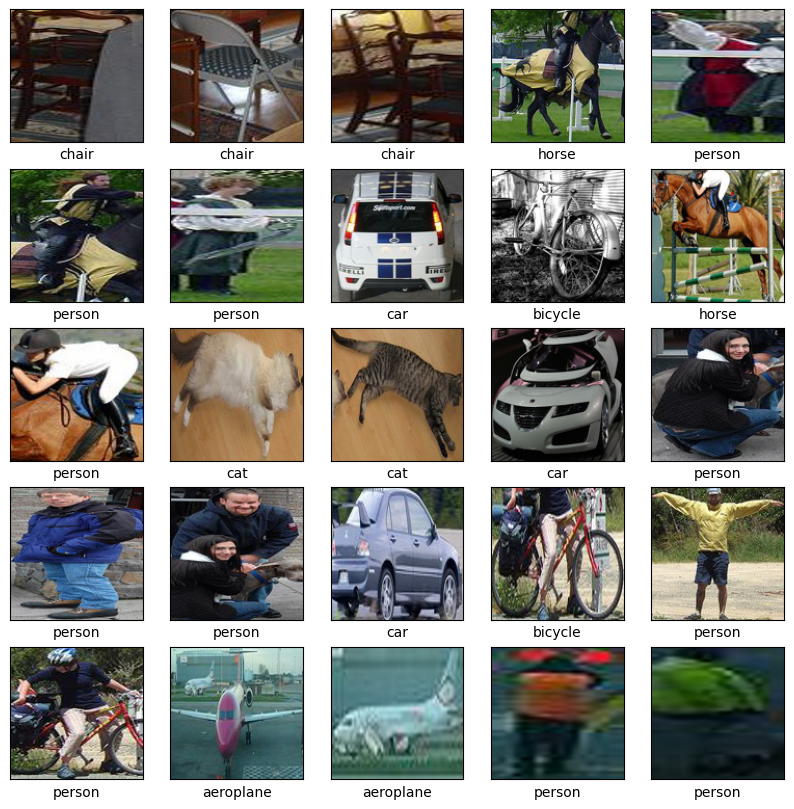

In [25]:
# 25개의 train_images를 plot에 표시
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [26]:
# 0 ~ 255 범위의 픽셀 값을 255로 나누어 0 ~ 1 범위로 축소하여 정규화한다.
train_images = train_images / 255.0
test_images = test_images / 255.0

학습모델 생성 과정, (참조 : Tensorflow Fashion MNIST dataset Classification)

In [90]:
# ReLU 활성화 함수를 이용한 은닉층이 1개인 model 생성
model = keras.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),
    # 입력 이미지를 평탄화

    layers.Dense(256, activation='relu'),
    # 첫 번째 Dense 층, 256 유닛

    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    # 두 번째 Dense 층, 256 유닛

    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu'),
    # 세 번째 Dense 층, 32 유닛

    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names), activation='softmax')
    # 최종 출력층
])

In [91]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 49152)             0         
                                                                 
 dense_54 (Dense)            (None, 256)               12583168  
                                                                 
 batch_normalization_43 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_55 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_44 (Bat  (None, 256)              1024      
 chNormalization)                                    

In [92]:
# 모델의 학습 설정
model.compile(optimizer = 'adam',
              # Adam 옵티마이저를 사용해 모델 최적화. Adam은 경사하강법의 기법 중 한 종류이며, 학습 속도를 조절하며 최적화를 수행

              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              # 모델의 손실함수로 범주형 교차 엔트로피 손실을 사용. 해당 함수는 예측된 확률 분포와 실제 분포 간의 차이를 계산

              metrics = ['accuracy']) # 모델의 평가 지표로 정확도를 사용

In [93]:
epochs = [] # 시도 횟수를 저장할 리스트
test_acc = [] # 시도 횟수마다 테스트 정확도를 저장할 리스트
for epoch in range(10):
    model.fit(train_images, train_labels, epochs=1, batch_size=32)

    test_loss, acc = model.evaluate(test_images, test_labels, verbose=2)
    # 모델을 주어진 테스트 데이터에 대한 예측을 수행하고, 손실과 정확도를 계산. 평가 과정을 자세히 출력

    test_acc.append(acc)
    # 정확도 값을 test_acc 리스트에 저장

    epochs.append(epoch + 1)
    # 해당하는 epoch 값을 epochs 리스트에 저장
    
# train_images를 입력으로 사용, 실제 레이블(train_labels)과 비교하고, 손실을 계산하고, 모델의 가중치를 업데이트
# 10번 반복

470/470 [==============================] - 12s 24ms/step - loss: 3.0678 - accuracy: 0.1585
224/224 - 1s - loss: 2.5043 - accuracy: 0.2736 - 1s/epoch - 6ms/step
470/470 [==============================] - 11s 24ms/step - loss: 2.5798 - accuracy: 0.2671
224/224 - 1s - loss: 2.3975 - accuracy: 0.3058 - 942ms/epoch - 4ms/step
470/470 [==============================] - 11s 24ms/step - loss: 2.4537 - accuracy: 0.2930
224/224 - 1s - loss: 2.3819 - accuracy: 0.3118 - 964ms/epoch - 4ms/step
470/470 [==============================] - 11s 23ms/step - loss: 2.4102 - accuracy: 0.3011
224/224 - 1s - loss: 2.3086 - accuracy: 0.3322 - 946ms/epoch - 4ms/step
470/470 [==============================] - 11s 23ms/step - loss: 2.3786 - accuracy: 0.3081
224/224 - 1s - loss: 2.3190 - accuracy: 0.3180 - 942ms/epoch - 4ms/step
470/470 [==============================] - 11s 24ms/step - loss: 2.3617 - accuracy: 0.3099
224/224 - 1s - loss: 2.2967 - accuracy: 0.3248 - 946ms/epoch - 4ms/step
470/470 [================

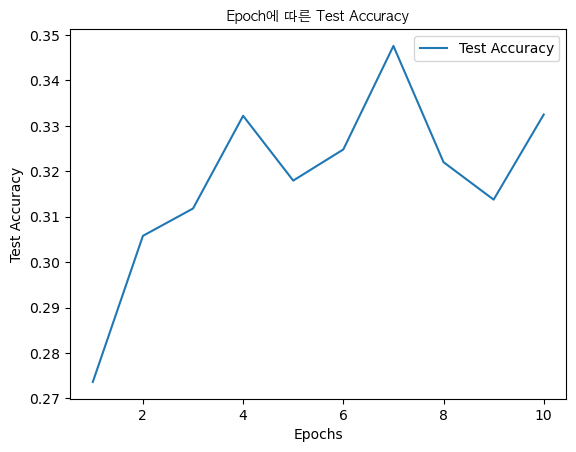

In [94]:
# epochs에 따른 test accuracy를 그래프로 시각화.
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Epoch에 따른 Test Accuracy', font = 'AppleGothic')
plt.legend()
plt.show()

In [89]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
# 모델을 주어진 테스트 데이터에 대한 예측을 수행하고, 손실과 정확도를 계산. 평가 과정을 자세히 출력

print('\nTest accuracy:', test_acc) # 정확도를 출력

224/224 - 1s - loss: 2.3253 - accuracy: 0.3277 - 1s/epoch - 6ms/step

Test accuracy: 0.32774049043655396


DNN과 CNN의 파라메터 수(약 1200만 vs. 약 1100만)에 따른 각각의 성능을 비교하기 위해 CNN 신경망 생성
(참조 : chatGPT - 128 * 128 이미지의 분류를 수행할 수 있는 TensorFlow CNN을 제작해 주십시오. Trainable Params는 약 1200만개 정도가 되어야 합니다.)

In [56]:
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    # 64개의 3x3 필터로 합성곱 연산 수행

    layers.BatchNormalization(),
    # 배치 정규화 층 추가하여 학습 안정화

    layers.MaxPooling2D((2, 2)),
    # 2x2 MaxPooling으로 이미지 크기 절반으로 축소

    layers.Conv2D(128, (3, 3), activation='relu'),
    # 128개의 3x3 필터로 합성곱 연산 수행

    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    # 256개의 3x3 필터로 합성곱 연산 수행

    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    # 512개의 3x3 필터로 합성곱 연산 수행

    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    # 평탄화 층

    layers.Dense(512, activation='relu'),
    # 512 유닛의 완전 연결 층

    layers.Dropout(0.5),
    # 과적합 방지를 위한 드롭아웃

    layers.Dense(len(class_names), activation='softmax')
    # 최종 출력층, 소프트맥스 활성화 함수 사용
])

In [57]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_33 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_34 (Bat  (None, 61, 61, 128)      512       
 chNormalization)                                                
                                                     

In [58]:
# 모델의 학습 설정
model.compile(optimizer = 'adam',
              # Adam 옵티마이저를 사용해 모델 최적화. Adam은 경사하강법의 기법 중 한 종류이며, 학습 속도를 조절하며 최적화를 수행

              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              # 모델의 손실함수로 범주형 교차 엔트로피 손실을 사용. 해당 함수는 예측된 확률 분포와 실제 분포 간의 차이를 계산

              metrics = ['accuracy']) # 모델의 평가 지표로 정확도를 사용

각 epoch(반복)에 대해 테스트 정확도가 가장 높은 모델을 찾기 위해 총 10번의 epoch마다 각각의 정확도를 저장하고, 테스트 정확도가 가장 높은 model을 h5 형태로 저장하는 과정

In [59]:
epochs = [] # 시도 횟수를 저장할 리스트
test_acc = [] # 시도 횟수마다 테스트 정확도를 저장할 리스트
best_acc = 0.0 # best_acc 값 초기화
best_model = None # best_model 초기화
best = 0

# 모델 학습시키기
for epoch in range(10):
    model.fit(train_images, train_labels, epochs=1, batch_size=32)

    test_loss, acc = model.evaluate(test_images, test_labels, verbose=2)
    # 모델을 주어진 테스트 데이터에 대한 예측을 수행하고, 손실과 정확도를 계산. 평가 과정을 자세히 출력

    test_acc.append(acc)
    # 정확도 값을 test_acc 리스트에 저장

    epochs.append(epoch + 1)
    # 해당하는 epoch 값을 epochs 리스트에 저장

    # 테스트 정확도가 가장 높다면 실행
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_model.save('best_model.h5') # 정확도가 가장 높은 모델을 best_model.h5으로 저장
        best = epoch + 1

470/470 [==============================] - 216s 456ms/step - loss: 3.8443 - accuracy: 0.2493
224/224 - 28s - loss: 2.7262 - accuracy: 0.2883 - 28s/epoch - 126ms/step
470/470 [==============================] - 212s 452ms/step - loss: 2.3149 - accuracy: 0.3486
224/224 - 27s - loss: 2.0049 - accuracy: 0.4107 - 27s/epoch - 121ms/step
470/470 [==============================] - 226s 480ms/step - loss: 2.0690 - accuracy: 0.4016
224/224 - 28s - loss: 2.0027 - accuracy: 0.4381 - 28s/epoch - 125ms/step
470/470 [==============================] - 227s 482ms/step - loss: 1.8766 - accuracy: 0.4435
224/224 - 28s - loss: 1.7079 - accuracy: 0.4892 - 28s/epoch - 125ms/step
470/470 [==============================] - 227s 483ms/step - loss: 1.7379 - accuracy: 0.4761
224/224 - 28s - loss: 1.6980 - accuracy: 0.5082 - 28s/epoch - 126ms/step
470/470 [==============================] - 230s 490ms/step - loss: 1.6211 - accuracy: 0.5033
224/224 - 28s - loss: 1.8141 - accuracy: 0.4695 - 28s/epoch - 126ms/step
470/

In [60]:
print('가장 정확도가 높았던 epoch :', best)

가장 정확도가 높았던 epoch : 10


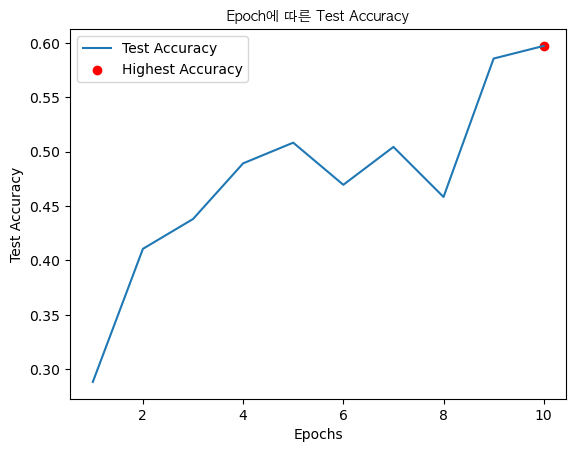

In [61]:
# epochs에 따른 test accuracy를 그래프로 시각화.
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Epoch에 따른 Test Accuracy', font = 'AppleGothic')

best_epoch = test_acc.index(best_acc) + 1

# best_epoch, best_acc 리스트를 이용해 plot 생성
plt.scatter(best_epoch, best_acc, color='red', label='Highest Accuracy')

plt.legend()
plt.show()

In [62]:
# 저장한 best_model을 load
best_model = keras.models.load_model('best_model.h5')

In [63]:
# best_model에 softmax 층을 추가하여, 확률값으로 변환하는 probability_model 생성
probability_model = keras.Sequential([best_model, layers.Softmax()])

# probability_model 테스트
test_predictions = probability_model.predict(test_images)

224/224 [==============================] - 29s 128ms/step


test_predictions에 대해 데이터 시각화 과정, (참조 : Tensorflow Fashion MNIST dataset Classification)

In [67]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(class_names)), fontsize = 5.5)
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

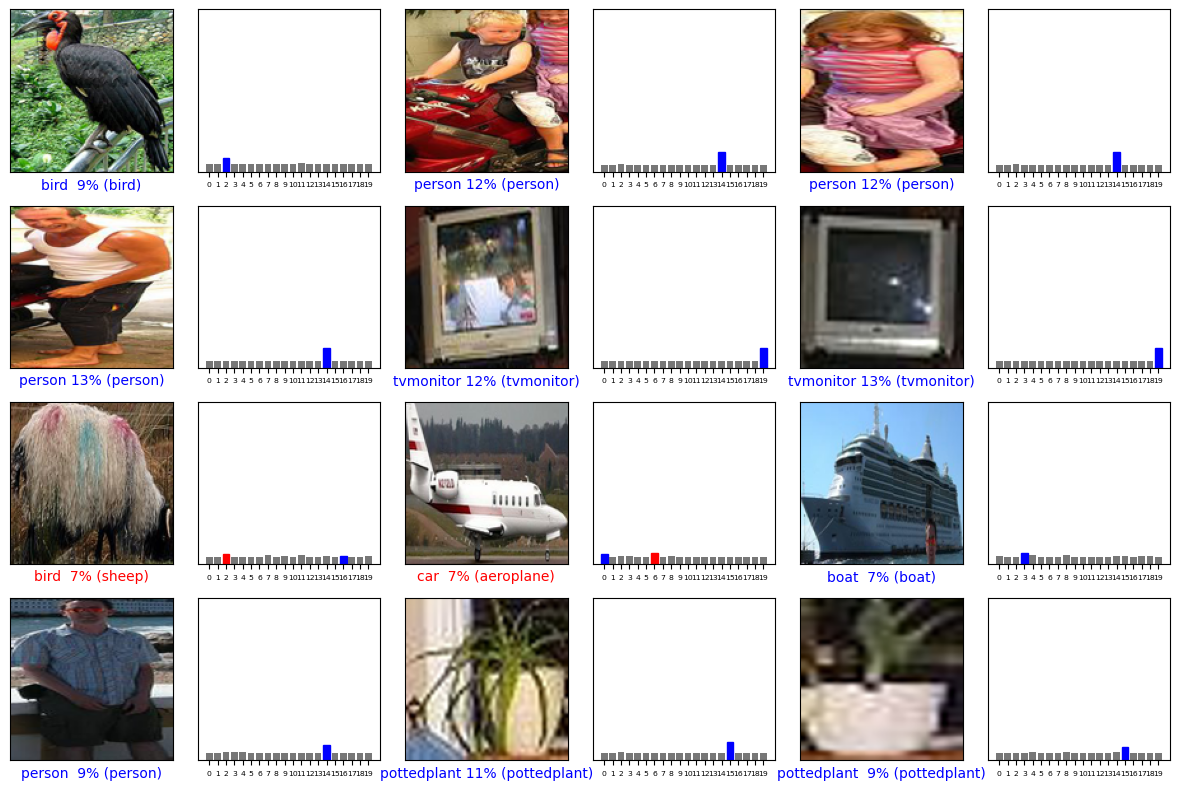

In [82]:
num_rows = 4
num_cols = 3
j = num_cols * 10 + num_rows
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+j, test_predictions[i+j], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+j, test_predictions[i+j], test_labels)
plt.tight_layout()
plt.show()

각각의 클래스에 대한 예측 정확도를 시각화하여 분석하기

In [79]:
prediction_class = np.array(range(len(test_predictions))) # 테스트 횟수(test_labels) 크기의 빈 배열 생성

for i in range(len(test_predictions)) :
    prediction_class[i] = np.argmax(test_predictions[i]) # test_predictions[i]의 최댓값 인덱스를 반환해 저장

print(prediction_class)
print(test_labels)

[ 6  3  3 ... 14 13 14]
[18  8 17 ... 14 13 14]


In [80]:
classes = np.unique(test_labels)

# 각 클래스의 총 개수와 예측값이 정답인 개수를 저장하는 리스트 생성
correct_predictions = np.zeros(len(classes))
total_predictions = np.zeros(len(classes))

for i, class_label in enumerate(classes):
    class_mask = (test_labels == class_label)
    class_predictions = prediction_class[class_mask]
    class_labels = test_labels[class_mask]
    correct_predictions[i] = np.sum(class_predictions == class_labels)
    total_predictions[i] = len(class_labels)

# 총 테스트 개수와 정답인 개수를 나누어 percentage_correct에 저장
percentage_correct = (correct_predictions / total_predictions) * 100

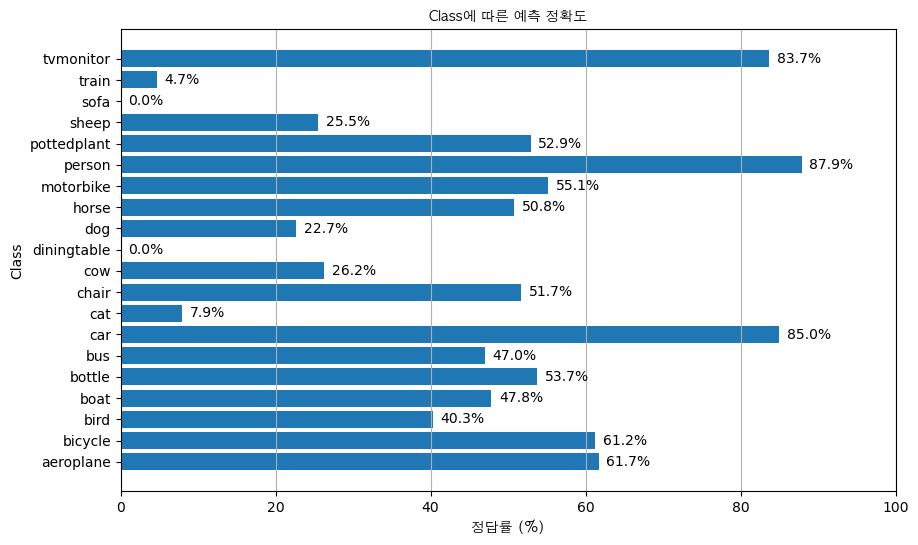

In [81]:
plt.figure(figsize=(10, 6))
plt.barh(class_names, percentage_correct)  # 가로 bar그래프 생성
plt.xlabel('정답률 (%)', font = 'AppleGothic')
plt.ylabel('Class')
plt.title('Class에 따른 예측 정확도', font = 'AppleGothic')
plt.xlim(0, 100)
plt.grid(axis='x')
for i, percentage in enumerate(percentage_correct):
    plt.text(percentage + 1, i, f'{percentage:.1f}%', va='center')
plt.show()

클래스 불균형 여부 분석

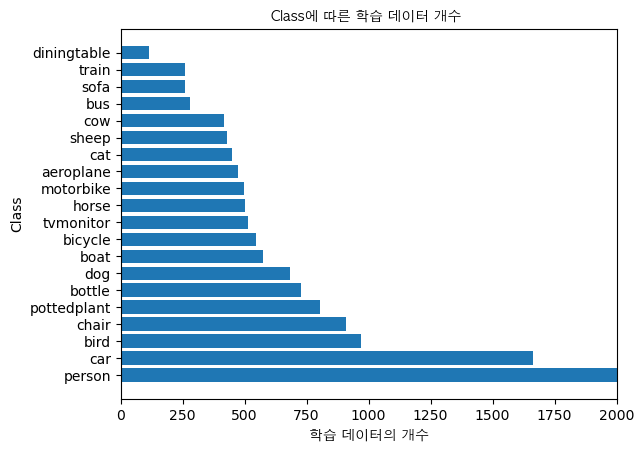

In [95]:
count_dict = {}
for label in train_labels:
    if label in count_dict:
        count_dict[label] += 1
    else:
        count_dict[label] = 1

result = []
for label, count in count_dict.items():
    result.append((label, count, class_names[label]))

result.sort(key=lambda x: x[1], reverse=True)

labels, counts, names = zip(*result)

plt.barh(names, counts)
plt.xlim(0, 2000)
plt.xlabel('학습 데이터의 개수', font = 'AppleGothic')
plt.ylabel('Class')
plt.title('Class에 따른 학습 데이터 개수 ', font = 'AppleGothic')

plt.show()

**ChatGPT 사용 내역 및 결과**

질문 내용 : 128 * 128 이미지의 분류를 수행할 수 있는 TensorFlow CNN을 제작해 주십시오. Trainable Params는 약 1200만개 정도가 되어야 합니다.
 - Tensorflow 라이브러리를 이용해 CNN을 구현하는 데에 도움을 받음.

![1번 질문](ChatGPT_QnA1.png)

질문 내용 : 각 index의 이미지를 plot하고, 해당 plot 옆에 예측 결과인 softmax의 값들 중 가장 높은 값을 highlight하여 plot 하는 코드를 제시해 주십시오. 해당 예측 값이 정답이면 파란색, 오답이면 빨간색의 막대 그래프로 출력해야 합니다. 각 행과 열은 각각 4, 3 입니다. 
 - 모델 예측 결과에 대해 이미지와 해당 이미지에 대한 예측 결과 Softmax 값을 시각화하여 출력하기 위해 사용

![2번 질문](ChatGPT_QnA2.png)